# Explore Air Team Data
Read in air team data from CKAN. Explore distributions by chemical and percentile.


## Description of Program
- program:    ip1_3av1_airdata
- task:       Read files from CKAN - Join HUA with File
- Version:    2025-12-12
- project:    Southeast Texas Urban Integrated Field Lab
- funding:	  DOE
- author:     Nathanael Rosenheim

## Step 0: Good Housekeeping

In [1]:
# 1. Import all packages
import pandas as pd     # For obtaining and cleaning tabular data
import geopandas as gpd # For obtaining and cleaning spatial data
import matplotlib.pyplot as plt # For plotting
import contextily as ctx # For adding basemaps
import os # For saving output to path
import zipfile # For handling zip files
import io # For handling in-memory data
import requests # For downloading data
import rasterio # For reading geotiff files

In [2]:
# 2. Check versions
import sys
print("Python Version     ", sys.version)
print("geopandas version: ", gpd.__version__)

Python Version      3.13.9 | packaged by conda-forge | (main, Oct 22 2025, 23:12:41) [MSC v.1944 64 bit (AMD64)]
geopandas version:  1.1.1


In [3]:
# 3. Check working directory
# Get information on current working directory (getcwd)
os.getcwd()

'c:\\Users\\nathanael99\\MyProjects\\GitHub\\integrate_people_theme1_cookbook'

In [4]:
#4. Store Program Name for output files to have the same name
programname = "ip1_3av1_airdata"
# Make directory to save output
#if not os.path.exists(programname):
#    os.mkdir(programname)

# Step 1: Obtain Data
Obtain publicly available data on CKAN

https://ckan.tacc.utexas.edu/organization/setx-uifl

### Simulated Percentile Concentrations of Hazardous Air Pollutants in Southeast Texas from the Comprehensive Air Quality Model with Extensions
https://ckan.tacc.utexas.edu/dataset/simulated-percentile-concentrations-of-hazardous-air-pollutants

Each file is named according to the following:

v720ut3_uifl_4km_1km_rtracv3_*_{gridname}_{species}_ppb_apr_oct_{statistics}.tif

- gridname is grd01 or grd02 specifying the modeling domain, uifl_4km or uifl_1km, respectively
- species can be antl (Acetonitrile), be13 (1,3-Butadiene), benz (Benzene), etbz (Ethylbenzene), etox (Ethylene Oxide), nhex (Hexane), strn (Styrene), tolu (Toluene) or xyln (mixed isomers of Xylenes).
- statistics has the format of pXX where XX is percentile, e.g. p50 represents the 50th percentile, or the word "mean" for mean.


In [5]:
# Add Air Pollution Data
air_pollution_url = "https://ckan.tacc.utexas.edu/dataset/c3c1b2b2-4d43-4603-b1c5-fc0877c279ae/resource/465209c8-f407-4eb2-99b3-4fc719e168c3/download/simulated_percentile_conc.zip"

# Dictionary to store the geotiff data organized by subfolders
air_pollution_dict = {}

# Mapping for species codes to full names
species_mapping = {
    'antl': 'Acetonitrile',
    'be13': '1,3-Butadiene',
    'benz': 'Benzene',
    'etbz': 'Ethylbenzene',
    'etox': 'Ethylene Oxide',
    'nhex': 'Hexane',
    'strn': 'Styrene',
    'tolu': 'Toluene',
    'xyln': 'Xylenes'
}

# Function to create descriptive key from filename
def create_descriptive_key(filename):
    """
    Parse filename structure and create descriptive key
    Filename structure: v720ut3_uifl_4km_1km_rtracv3_*_{gridname}_{species}_ppb_apr_oct_{statistics}.tif
        - gridname is grd01 or grd02 specifying the modeling domain, uifl_4km or uifl_1km, respectively
        - species can be antl (Acetonitrile), be13 (1,3-Butadiene), benz (Benzene), etbz (Ethylbenzene), etox (Ethylene Oxide), nhex (Hexane), strn (Styrene), tolu (Toluene) or xyln (mixed isomers of Xylenes).
        - statistics has the format of pXX where XX is percentile, e.g. p50 represents the 50th percentile, or the word "mean" for mean.
    example: 
        - Filename = v720ut3_uifl_4km_1km_rtracv3_bzhx_grd02_benz_ppb_apr_oct_p75
            - key = Benzene 75th percentile 1km
    """
    parts = filename.split('_')
    
    # Extract components from filename parts
    gridname = None
    species = None
    statistics = None
    
    for i, part in enumerate(parts):
        # Find gridname (grd01 or grd02)
        if part in ['grd01', 'grd02']:
            gridname = part
        # Find species code (should be after gridname)
        elif gridname and part in species_mapping:
            species = part
        # Find statistics (last meaningful part before extension)
        elif part.startswith('p') and part[1:].isdigit():
            statistics = part
        elif part == 'mean':
            statistics = part
    
    # Format statistics for key
    if statistics and statistics.startswith('p'):
        stat_display = f"p{statistics[1:]}"  # Keep percentile format shorter
    elif statistics == 'mean':
        stat_display = 'mean'
    else:
        stat_display = statistics if statistics else 'unknown'
    
    # Create descriptive key (shorter format)
    descriptive_key = stat_display
    
    return descriptive_key

# Download and read TIFF files from the zip
response = requests.get(air_pollution_url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # Get list of all files in the zip
    file_list = z.namelist()
    
    # Filter for .tif files
    tif_files = [f for f in file_list if f.endswith('.tif') or f.endswith('.tiff')]
    
    print(f"Found {len(tif_files)} TIFF files in total")
    
    # Process each TIFF file and organize by subfolder structure
    for tif_file in tif_files:
        # Parse the file path
        path_parts = tif_file.split('/')
        
        if len(path_parts) >= 3:  # resolution/species/filename
            resolution_dir = path_parts[0]  # e.g., 'uifl_1km' or 'uifl_4km'
            species_dir = path_parts[1]     # e.g., 'benz', 'tolu', etc.
            filename = os.path.splitext(path_parts[2])[0]  # filename without extension
            
            # Create nested dictionary structure: resolution -> species -> statistic
            if resolution_dir not in air_pollution_dict:
                air_pollution_dict[resolution_dir] = {}
            
            # Get species full name
            species_name = species_mapping.get(species_dir, species_dir)
            
            if species_name not in air_pollution_dict[resolution_dir]:
                air_pollution_dict[resolution_dir][species_name] = {}
            
            # Create descriptive key for the statistic
            statistic_key = create_descriptive_key(filename)
            
            # Read the TIFF file data
            with z.open(tif_file) as file_data:
                # Use rasterio to read the geotiff
                with rasterio.open(file_data) as src:
                    # Store the rasterio dataset in the nested dictionary
                    air_pollution_dict[resolution_dir][species_name][statistic_key] = {
                        'data': src.read(),  # Read all bands
                        'transform': src.transform,
                        'crs': src.crs,
                        'meta': src.meta,
                        'bounds': src.bounds,
                        'width': src.width,
                        'height': src.height,
                        'original_filename': filename,  # Keep original filename for reference
                        'file_path': tif_file  # Keep original file path
                    }

print(f"\nSuccessfully organized {len(tif_files)} geotiff files into nested dictionary")
print(f"Resolution levels: {list(air_pollution_dict.keys())}")

# Display the structure
for resolution in air_pollution_dict.keys():
    species_count = len(air_pollution_dict[resolution])
    print(f"\n{resolution}: {species_count} species")
    for species in air_pollution_dict[resolution].keys():
        stat_count = len(air_pollution_dict[resolution][species])
        stats = list(air_pollution_dict[resolution][species].keys())
        print(f"  {species}: {stat_count} statistics ({', '.join(sorted(stats))})")

Found 162 TIFF files in total

Successfully organized 162 geotiff files into nested dictionary
Resolution levels: ['uifl_1km', 'uifl_4km']

uifl_1km: 9 species
  Benzene: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  Acetonitrile: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  1,3-Butadiene: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  Styrene: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  Ethylene Oxide: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  Toluene: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  Hexane: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  Ethylbenzene: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  Xylenes: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)

uifl_4km: 9 species
  Benzene: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  Acetonitrile: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)


# Step 3: Explore Data

In [6]:
# Texas cities coordinates for geographic context
texas_cities = {
    'Houston': {'lat': 29.7604, 'lon': -95.3698},
    'Beaumont': {'lat': 30.0860, 'lon': -94.1265}, 
    'Port Arthur': {'lat': 29.8849, 'lon': -93.9300},
    'Orange': {'lat': 30.0927, 'lon': -93.7565},
    'Bridge City': {'lat': 30.0254, 'lon': -93.8432},
    'Lufkin': {'lat': 31.3382, 'lon': -94.7291},
    'Tyler': {'lat': 32.3513, 'lon': -95.3011}
}

In [7]:
air_pollution_dict['uifl_1km']['Benzene']['p25'].keys()

dict_keys(['data', 'transform', 'crs', 'meta', 'bounds', 'width', 'height', 'original_filename', 'file_path'])

In [8]:
# Create bounding box for air pollution data extent and plot on contextily base map
import shapely.geometry as sg
from shapely.geometry import box
import contextily as ctx

def create_data_extent_box(data_dict):
    """Create a bounding box polygon from raster data bounds"""
    # Get the bounds from the raster data
    bounds = data_dict['bounds']
    
    # Create a bounding box polygon (minx, miny, maxx, maxy)
    bbox = box(bounds.left, bounds.bottom, bounds.right, bounds.top)
    
    return bbox, bounds

def plot_data_extent_on_basemap(resolution='uifl_1km', species='Benzene', statistic='p25'):
    """Plot data extent as polygon on contextily base map"""
    
    # Get the data dictionary
    data_dict = air_pollution_dict[resolution][species][statistic]
    
    # Create bounding box polygon
    bbox_geom, bounds = create_data_extent_box(data_dict)
    
    # Create a GeoDataFrame with the bounding box
    bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox_geom], crs=data_dict['crs'])
    
    # Convert to WGS84 (EPSG:4326) for standard lat/lon decimal degrees
    bbox_wgs84 = bbox_gdf.to_crs(epsg=4326)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot the bounding box polygon
    bbox_wgs84.boundary.plot(ax=ax, color='red', linewidth=3, label='Data Extent')
    bbox_wgs84.plot(ax=ax, alpha=0.2, color='red', edgecolor='red', linewidth=3)
    
    # Add contextily base map
    try:
        ctx.add_basemap(ax, crs=bbox_wgs84.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
        basemap_source = "OpenStreetMap"
    except:
        try:
            # Fallback to Cartodb if OpenStreetMap fails
            ctx.add_basemap(ax, crs=bbox_wgs84.crs.to_string(), source=ctx.providers.CartoDB.Positron)
            basemap_source = "CartoDB Positron"
        except:
            print("Warning: Could not add base map")
            basemap_source = "None"
    
    # Add Texas cities as points
    cities_data = []
    for city_name, coords in texas_cities.items():
        cities_data.append({
            'city': city_name,
            'geometry': sg.Point(coords['lon'], coords['lat'])
        })
    
    # Create cities GeoDataFrame (already in EPSG:4326)
    cities_gdf = gpd.GeoDataFrame(cities_data, crs='EPSG:4326')
    
    # Plot cities
    cities_gdf.plot(ax=ax, color='blue', markersize=100, alpha=0.8, 
                   edgecolor='white', linewidth=2, zorder=10)
    
    # Add city labels
    for idx, row in cities_gdf.iterrows():
        ax.annotate(row['city'], 
                   (row.geometry.x, row.geometry.y),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=10, fontweight='bold', color='black',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
                   zorder=11)
    
    # Set plot properties
    ax.set_title(f'Air Pollution Data Extent\n{species} {statistic} ({resolution})', 
                fontsize=14, fontweight='bold')
    
    # Add legend
    ax.legend(loc='upper left')
    
    # Set axis labels
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    # Display bounds information
    print(f"Data Extent Information:")
    print(f"  Resolution: {resolution}")
    print(f"  Species: {species}")
    print(f"  Statistic: {statistic}")
    print(f"  CRS: {data_dict['crs']}")
    print(f"  Bounds (original CRS):")
    print(f"    West:  {bounds.left:.6f}")
    print(f"    East:  {bounds.right:.6f}")
    print(f"    South: {bounds.bottom:.6f}")
    print(f"    North: {bounds.top:.6f}")
    print(f"  Area: {bbox_geom.area:.2e} square units")
    
    plt.tight_layout()
    plt.show()
    
    return bbox_gdf

In [9]:
# Compare extents of different resolutions
def plot_multiple_extents_comparison():
    """Compare the extents of 1km and 4km resolution data"""
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Get both resolution extents
    data_1km = air_pollution_dict['uifl_1km']['Benzene']['p25']
    data_4km = air_pollution_dict['uifl_4km']['Benzene']['p25']
    
    # Create bounding boxes
    bbox_1km, bounds_1km = create_data_extent_box(data_1km)
    bbox_4km, bounds_4km = create_data_extent_box(data_4km)
    
    # Create GeoDataFrames
    bbox_1km_gdf = gpd.GeoDataFrame([1], geometry=[bbox_1km], crs=data_1km['crs'])
    bbox_4km_gdf = gpd.GeoDataFrame([1], geometry=[bbox_4km], crs=data_4km['crs'])
    
    # Convert to WGS84 (EPSG:4326) for standard lat/lon decimal degrees
    bbox_1km_wgs = bbox_1km_gdf.to_crs(epsg=4326)
    bbox_4km_wgs = bbox_4km_gdf.to_crs(epsg=4326)
    
    # Plot both extents
    bbox_1km_wgs.boundary.plot(ax=ax, color='red', linewidth=3, label='1km Resolution')
    bbox_1km_wgs.plot(ax=ax, alpha=0.2, color='red', edgecolor='red', linewidth=3)
    
    bbox_4km_wgs.boundary.plot(ax=ax, color='blue', linewidth=3, label='4km Resolution', linestyle='--')
    bbox_4km_wgs.plot(ax=ax, alpha=0.1, color='blue', edgecolor='blue', linewidth=3)
    
    # Add base map
    try:
        ctx.add_basemap(ax, crs=bbox_1km_wgs.crs.to_string(), source=ctx.providers.CartoDB.Positron)
        basemap_source = "CartoDB Positron"
    except:
        print("Warning: Could not add base map")
        basemap_source = "None"
    
    # Add Texas cities
    cities_data = []
    for city_name, coords in texas_cities.items():
        cities_data.append({
            'city': city_name,
            'geometry': sg.Point(coords['lon'], coords['lat'])
        })
    
    cities_gdf = gpd.GeoDataFrame(cities_data, crs='EPSG:4326')
    
    cities_gdf.plot(ax=ax, color='darkgreen', markersize=80, alpha=0.9, 
                   edgecolor='white', linewidth=2, zorder=10)
    
    # Add city labels
    for idx, row in cities_gdf.iterrows():
        ax.annotate(row['city'], 
                   (row.geometry.x, row.geometry.y),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=9, fontweight='bold', color='black',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8),
                   zorder=11)
    
    ax.set_title('Air Pollution Data Coverage Comparison\nSoutheast Texas Urban Integrated Field Lab', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=12)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison info
    print("Data Coverage Comparison:")
    print(f"  1km Resolution Area: {bbox_1km.area:.2e} square units")
    print(f"  4km Resolution Area: {bbox_4km.area:.2e} square units")
    print(f"  Coverage Overlap: {'Yes' if bbox_1km.intersects(bbox_4km) else 'No'}")

Data Extent Information:
  Resolution: uifl_1km
  Species: Benzene
  Statistic: p25
  CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6370000,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",40],PARAMETER["central_meridian",-97],PARAMETER["standard_parallel_1",33],PARAMETER["standard_parallel_2",45],PARAMETER["false_easting",-252000],PARAMETER["false_northing",1152000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  Bounds (original CRS):
    West:  0.000000
    East:  72000.000000
    South: 0.000000
    North: 72000.000000
  Area: 5.18e+09 square units


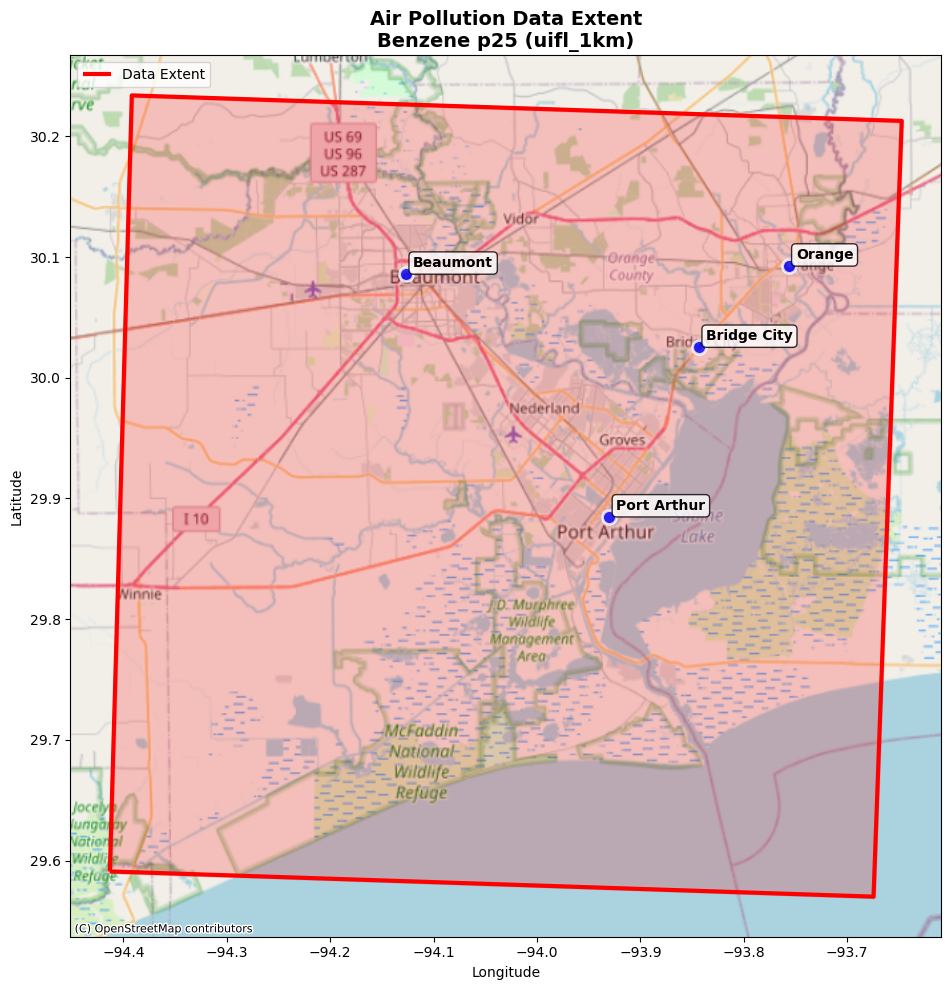

In [10]:
# Test the updated functions with WGS84 (standard lat/lon decimal degrees)
extent_gdf_wgs84 = plot_data_extent_on_basemap('uifl_1km', 'Benzene', 'p25')

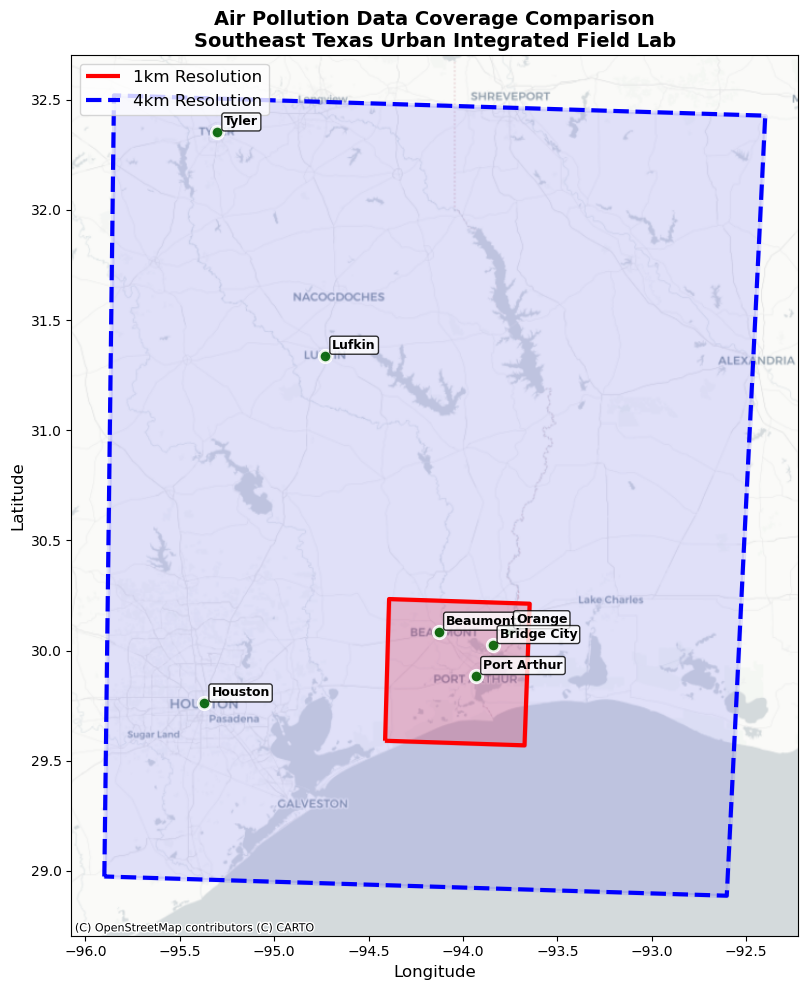

Data Coverage Comparison:
  1km Resolution Area: 5.18e+09 square units
  4km Resolution Area: 1.28e+11 square units
  Coverage Overlap: Yes


In [11]:
plot_multiple_extents_comparison()

In [12]:
# Calculate species-specific p100 scales for consistent plotting
def get_species_p100_scale(resolution, species):
    """Get the p100 maximum value for a specific species and resolution for scaling"""
    if 'p100' in air_pollution_dict[resolution][species]:
        p100_data = air_pollution_dict[resolution][species]['p100']['data'][0]
        p100_max = p100_data.max()
        return 0, p100_max  # Always start scale at 0
    else:
        print(f"Warning: p100 not found for {resolution} {species}")
        return 0, 1  # Default fallback

# Display all species p100 scales
print("Species-specific p100 scales (0 to species max):")
for resolution in air_pollution_dict.keys():
    print(f"\n{resolution}:")
    for species in air_pollution_dict[resolution].keys():
        if 'p100' in air_pollution_dict[resolution][species]:
            p100_data = air_pollution_dict[resolution][species]['p100']['data'][0]
            p100_max = p100_data.max()
            print(f"  {species:>15}: 0.000 - {p100_max:.3f} ppb")

Species-specific p100 scales (0 to species max):

uifl_1km:
          Benzene: 0.000 - 20.884 ppb
     Acetonitrile: 0.000 - 28.233 ppb
    1,3-Butadiene: 0.000 - 18.068 ppb
          Styrene: 0.000 - 3.564 ppb
   Ethylene Oxide: 0.000 - 0.893 ppb
          Toluene: 0.000 - 13.604 ppb
           Hexane: 0.000 - 70.650 ppb
     Ethylbenzene: 0.000 - 2.742 ppb
          Xylenes: 0.000 - 7.115 ppb

uifl_4km:
          Benzene: 0.000 - 85.573 ppb
     Acetonitrile: 0.000 - 115.319 ppb
    1,3-Butadiene: 0.000 - 67.924 ppb
          Styrene: 0.000 - 13.098 ppb
   Ethylene Oxide: 0.000 - 0.217 ppb
          Toluene: 0.000 - 55.556 ppb
           Hexane: 0.000 - 19.304 ppb
     Ethylbenzene: 0.000 - 0.627 ppb
          Xylenes: 0.000 - 29.412 ppb


In [16]:
# Enhanced function to overlay air pollution data on base map with extent
import numpy as np
from matplotlib.colors import LogNorm
import rasterio.warp
from rasterio.enums import Resampling

def get_species_log_scale_range(air_pollution_dict, resolution, species):
    """
    Calculate consistent log scale range for a species across all statistics
    Returns (log_vmin, log_vmax) that can be used for all plots of this species
    """
    all_nonzero_values = []
    all_max_values = []
    
    # Collect data from all statistics for this species
    for statistic in air_pollution_dict[resolution][species]:
        data = air_pollution_dict[resolution][species][statistic]['data'][0]
        nonzero_data = data[data > 0]
        if len(nonzero_data) > 0:
            all_nonzero_values.extend(nonzero_data.flatten())
            all_max_values.append(data.max())
    
    if len(all_nonzero_values) > 0:
        # Use the minimum non-zero value across all statistics
        global_min = np.min(all_nonzero_values)
        # Use the maximum value across all statistics  
        global_max = np.max(all_max_values)
        
        # Set log_vmin to be 10% of the global minimum for better visualization
        log_vmin = global_min * 0.1
        log_vmax = global_max
    else:
        # Fallback values
        log_vmin = 1e-6
        log_vmax = 1.0
    
    return log_vmin, log_vmax

# Enhanced function to overlay air pollution data on base map with extent
import numpy as np
from matplotlib.colors import LogNorm
import rasterio.warp
from rasterio.enums import Resampling

def get_species_log_scale_range(air_pollution_dict, resolution, species):
    """
    Calculate consistent log scale range for a species across all statistics
    Returns (log_vmin, log_vmax) that can be used for all plots of this species
    """
    all_nonzero_values = []
    all_max_values = []
    
    # Collect data from all statistics for this species
    for statistic in air_pollution_dict[resolution][species]:
        data = air_pollution_dict[resolution][species][statistic]['data'][0]
        nonzero_data = data[data > 0]
        if len(nonzero_data) > 0:
            all_nonzero_values.extend(nonzero_data.flatten())
            all_max_values.append(data.max())
    
    if len(all_nonzero_values) > 0:
        # Use the minimum non-zero value across all statistics
        global_min = np.min(all_nonzero_values)
        # Use the maximum value across all statistics  
        global_max = np.max(all_max_values)
        
        # Set log_vmin to be 10% of the global minimum for better visualization
        log_vmin = global_min * 0.1
        log_vmax = global_max
    else:
        # Fallback values
        log_vmin = 1e-6
        log_vmax = 1.0
    
    return log_vmin, log_vmax

def plot_data_extent_with_overlay(air_pollution_dict,
                                 resolution='uifl_1km', 
                                 species='Benzene', 
                                 statistic='p25',
                                 show_data_overlay=True, log_scale=True, alpha=0.7,
                                 save_png=False, output_dir='maps'):
    """
    Plot data extent as polygon on contextily base map with optional air pollution data overlay
    
    Parameters:
    - resolution: str, resolution folder ('uifl_1km' or 'uifl_4km')
    - species: str, species name to plot
    - statistic: str, statistic to plot ('p25', 'p50', etc.)
    - show_data_overlay: bool, whether to overlay the actual pollution data
    - log_scale: bool, use logarithmic color scale for better visualization 
    - alpha: float, transparency of the data overlay (0-1)
    - save_png: bool, whether to save the plot as PNG file
    - output_dir: str, directory to save PNG files (default: 'maps')
    """
    
    # Get the data dictionary
    data_dict = air_pollution_dict[resolution][species][statistic]
    
    # Create bounding box polygon
    bbox_geom, bounds = create_data_extent_box(data_dict)
    
    # Create a GeoDataFrame with the bounding box
    bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox_geom], crs=data_dict['crs'])
    
    # Convert to WGS84 (EPSG:4326) for standard lat/lon decimal degrees
    bbox_wgs84 = bbox_gdf.to_crs(epsg=4326)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Plot the bounding box polygon (lighter if data overlay is shown)
    boundary_alpha = 0.6 if show_data_overlay else 1.0
    fill_alpha = 0.1 if show_data_overlay else 0.2
    
    bbox_wgs84.boundary.plot(ax=ax, color='red', linewidth=2, alpha=boundary_alpha, label='Data Extent')
    bbox_wgs84.plot(ax=ax, alpha=fill_alpha, color='red', edgecolor='red', linewidth=2)
    
    # Add contextily base map
    try:
        ctx.add_basemap(ax, crs=bbox_wgs84.crs.to_string(), source=ctx.providers.CartoDB.Positron)
        basemap_source = "CartoDB Positron"
    except:
        try:
            ctx.add_basemap(ax, crs=bbox_wgs84.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
            basemap_source = "OpenStreetMap"
        except:
            print("Warning: Could not add base map")
            basemap_source = "None"
    
    # Add air pollution data overlay if requested
    if show_data_overlay:
        # Get the raster data
        raster_data = data_dict['data'][0]  # First band
        transform = data_dict['transform']
        
        # Get species-specific scaling
        if 'p100' in air_pollution_dict[resolution][species]:
            scale_min = 0
            scale_max = air_pollution_dict[resolution][species]['p100']['data'][0].max()
        else:
            scale_min = 0
            scale_max = raster_data.max()
        
        # Reproject the raster data to WGS84 for proper alignment
        from rasterio.warp import reproject, calculate_default_transform
        from rasterio.enums import Resampling
        
        # Calculate the transform and dimensions for WGS84 reprojection
        dst_crs = 'EPSG:4326'  # WGS84
        dst_transform, dst_width, dst_height = calculate_default_transform(
            data_dict['crs'], dst_crs, 
            data_dict['width'], data_dict['height'], 
            *data_dict['bounds']
        )
        
        # Create destination array
        dst_array = np.zeros((dst_height, dst_width), dtype=raster_data.dtype)
        
        # Reproject the data
        reproject(
            source=raster_data,
            destination=dst_array,
            src_transform=transform,
            src_crs=data_dict['crs'],
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear
        )
        
        # Calculate the extent for the reprojected data
        from rasterio.transform import array_bounds
        bounds = array_bounds(dst_height, dst_width, dst_transform)
        extent = [bounds[0], bounds[2], bounds[1], bounds[3]]  # [left, right, bottom, top]
        
        # Handle scaling for visualization using the reprojected data
        # Create a mask for zero/nodata values to make them transparent
        data_mask = dst_array > 0  # Only show pixels with actual data values
        
        if log_scale and dst_array.max() > 0:
            # Get consistent log scale range for this species across all statistics
            log_vmin, log_vmax = get_species_log_scale_range(air_pollution_dict, resolution, species)
            
            # Replace zeros with small values for log scale, but keep mask for transparency
            plot_data = np.where(dst_array <= 0, log_vmin, dst_array)
            norm = LogNorm(vmin=log_vmin, vmax=log_vmax)
            
            # Update scale_max to use consistent species-wide maximum
            scale_max = log_vmax
        else:
            plot_data = dst_array
            norm = plt.Normalize(vmin=scale_min, vmax=scale_max)
        
        # Create a masked array where zero/nodata values are transparent
        masked_data = np.ma.masked_where(~data_mask, plot_data)
        
        # Plot the reprojected raster data with transparency for nodata areas
        im = ax.imshow(masked_data, extent=extent, alpha=alpha, cmap='viridis', 
                      norm=norm, zorder=5)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, shrink=0.6, pad=0.01)
        cbar.set_label(f'{species} Concentration (ppb)', fontsize=12)
        
        # Set custom colorbar ticks for log scale
        if log_scale:
            standard_ticks = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
            standard_labels = ['0.001', '0.01', '0.1', '1', '10', '100']
            
            valid_ticks = []
            valid_labels = []
            
            for tick, label in zip(standard_ticks, standard_labels):
                if log_vmin <= tick <= scale_max:
                    valid_ticks.append(tick)
                    valid_labels.append(label)
            
            if valid_ticks:
                cbar.set_ticks(valid_ticks)
                cbar.set_ticklabels(valid_labels)
    
    # Add Texas cities as points
    cities_data = []
    for city_name, coords in texas_cities.items():
        cities_data.append({
            'city': city_name,
            'geometry': sg.Point(coords['lon'], coords['lat'])
        })
    
    # Create cities GeoDataFrame (already in EPSG:4326)
    cities_gdf = gpd.GeoDataFrame(cities_data, crs='EPSG:4326')
    
    # Plot cities with higher z-order to appear on top
    cities_gdf.plot(ax=ax, color='white', markersize=120, alpha=0.9, 
                   edgecolor='black', linewidth=2, zorder=15)
    cities_gdf.plot(ax=ax, color='blue', markersize=80, alpha=0.9, 
                   edgecolor='white', linewidth=1, zorder=16)
    
    # Add city labels
    for idx, row in cities_gdf.iterrows():
        ax.annotate(row['city'], 
                   (row.geometry.x, row.geometry.y),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=10, fontweight='bold', color='black',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9),
                   zorder=17)
    
    # Set plot properties
    scale_type = "with Logarithmic Scale" if (show_data_overlay and log_scale) else ""
    overlay_text = "with Data Overlay" if show_data_overlay else ""
    resolution_label = "1km" if "1km" in resolution else "4km"
    
    # Create title with data range if overlay is shown
    title = f'{species} {statistic} ({resolution_label})\n{overlay_text} {scale_type}'
    if show_data_overlay:
        title += f'\nData Range: {raster_data.min():.3f} - {raster_data.max():.3f} ppb'
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Add legend
    legend_elements = []
    if show_data_overlay:
        from matplotlib.patches import Patch
        legend_elements.append(Patch(facecolor='red', alpha=0.6, label='Data Extent'))
    else:
        legend_elements.append(ax.collections[0])  # Data extent boundary
    
    ax.legend(handles=legend_elements, loc='upper left', fontsize=10)
    
    # Set axis labels with degree symbols
    ax.set_xlabel('Longitude (°)', fontsize=12)
    ax.set_ylabel('Latitude (°)', fontsize=12)
    
    # Display summary information
    print(f"Enhanced Map Information:")
    print(f"  Resolution: {resolution}")
    print(f"  Species: {species}")
    print(f"  Statistic: {statistic}")
    print(f"  Data Overlay: {'Yes' if show_data_overlay else 'No'}")
    print(f"  Scale: {'Logarithmic' if (show_data_overlay and log_scale) else 'Linear'}")
    if show_data_overlay:
        print(f"  Data Range: {dst_array.min():.3f} - {dst_array.max():.3f} ppb")
        if log_scale:
            print(f"  Consistent Log Scale: {log_vmin:.6f} - {scale_max:.3f} ppb (same for all {species} statistics)")
        print(f"  Reprojected to: WGS84 (EPSG:4326)")
        print(f"  Original size: {raster_data.shape}, Reprojected size: {dst_array.shape}")
    print(f"  Base Map: {basemap_source}")
    
    # Save the plot if requested
    if save_png:
        import os
        
        # Create output directory if it doesn't exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        # Get the original filename from the data dictionary
        data_entry = air_pollution_dict[resolution][species][statistic]
        original_filename = data_entry['original_filename']
        
        # Extract the base filename without extension and add .png
        base_filename = original_filename.replace('.tif', '').replace('.tiff', '')
        png_filename = f"{base_filename}.png"
        
        # Save the plot
        save_path = os.path.join(output_dir, png_filename)
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved map to: {save_path}")
    
    plt.tight_layout()
    plt.show()
    
    return bbox_gdf

Enhanced Map Information:
  Resolution: uifl_1km
  Species: Benzene
  Statistic: mean
  Data Overlay: Yes
  Scale: Logarithmic
  Data Range: 0.000 - 0.210 ppb
  Consistent Log Scale: 0.000303 - 20.884 ppb (same for all Benzene statistics)
  Reprojected to: WGS84 (EPSG:4326)
  Original size: (72, 72), Reprojected size: (69, 80)
  Base Map: CartoDB Positron
Saved map to: ip1_3av1_airdata\v720ut3_uifl_4km_1km_rtracv3_bzhx_grd02_benz_ppb_apr_oct_mean.png


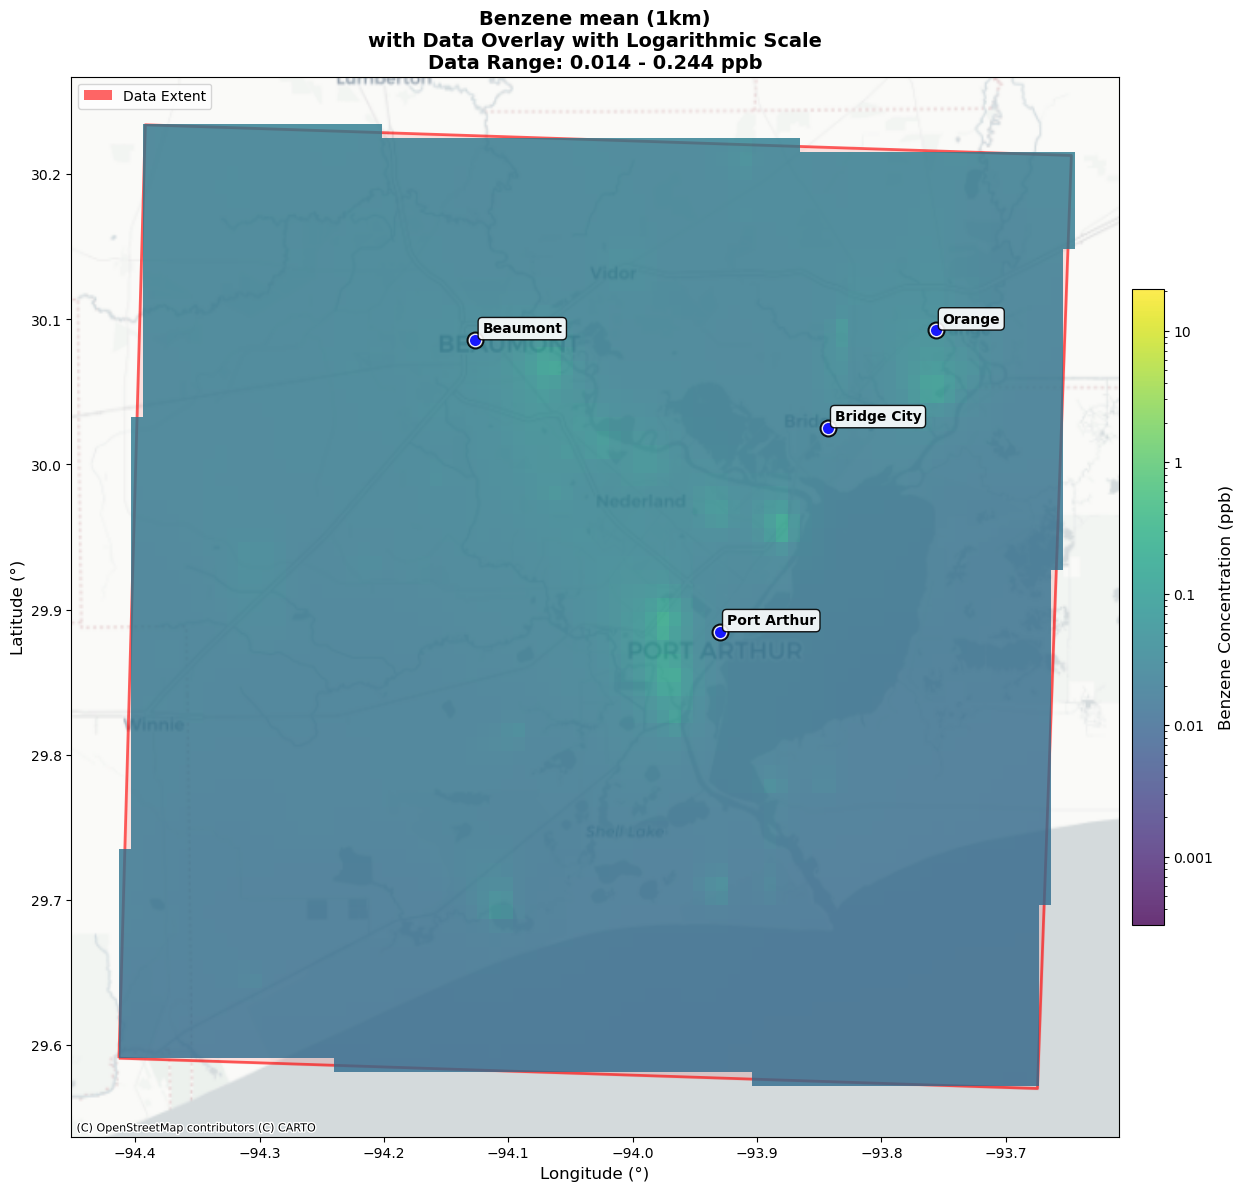

In [41]:
# Test the enhanced function
enhanced_gdf = plot_data_extent_with_overlay(air_pollution_dict, 'uifl_1km', 'Benzene', 'mean',
                                           show_data_overlay=True, 
                                           log_scale=True, 
                                           alpha=0.8, 
                                           save_png=True,
                                           output_dir = programname)

In [ ]:
import ipywidgets as widgets
from IPython.display import display

def interactive_species_percentile_viewer(air_pollution_dict, resolution='uifl_1km', enable_save=True):
    """
    Create an interactive viewer to scroll through different species and percentile maps
    """
    # Get available species
    available_species = list(air_pollution_dict[resolution].keys())
    
    def update_plot(species, statistic):
        """Update the plot based on selected species and statistic"""
        plt.clf()  # Clear the current figure
        
        # Call your existing function
        plot_data_extent_with_overlay(
            air_pollution_dict, 
            resolution=resolution, 
            species=species, 
            statistic=statistic,
            show_data_overlay=True, 
            log_scale=True, 
            alpha=0.7
        )
        
    def save_current_map(button):
        """Save the currently displayed map as PNG"""
        species = species_dropdown.value
        statistic = statistic_slider.value
        
        # Call the function with save enabled
        plot_data_extent_with_overlay(
            air_pollution_dict, 
            resolution=resolution, 
            species=species, 
            statistic=statistic,
            show_data_overlay=True, 
            log_scale=True, 
            alpha=0.7,
            save_png=True,
            output_dir=programname
        )
    
    # Get available statistics for the first species (assuming all have same stats)
    first_species = available_species[0]
    available_stats = list(air_pollution_dict[resolution][first_species].keys())
    percentile_stats = [stat for stat in available_stats if stat.startswith('p')]
    percentile_stats = sorted(percentile_stats, key=lambda x: int(x[1:]))  # Sort by percentile number
    
    # Add mean if available
    if 'mean' in available_stats:
        percentile_stats.append('mean')
    
    # Create interactive widgets
    species_dropdown = widgets.Dropdown(
        options=available_species,
        value=available_species[0],
        description='Species:',
        style={'description_width': 'initial'}
    )
    
    statistic_slider = widgets.SelectionSlider(
        options=percentile_stats,
        value=percentile_stats[0],
        description='Percentile:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        style={'description_width': 'initial'}
    )
    
    # Create save button
    save_button = widgets.Button(
        description='Save Current Map as PNG',
        disabled=not enable_save,
        button_style='success',
        tooltip='Save the currently displayed map as PNG file',
        icon='download'
    )
    save_button.on_click(save_current_map)
    
    # Create the interactive plot
    interactive_plot = widgets.interactive(
        update_plot, 
        species=species_dropdown,
        statistic=statistic_slider
    )
    
    # Create layout with save button if enabled
    if enable_save:
        display(widgets.VBox([
            widgets.HBox([species_dropdown, statistic_slider]),
            save_button,
            interactive_plot.children[-1]  # The plot output
        ]))
    else:
        # Display the widget without save button
        display(interactive_plot)

# Usage example:
# interactive_species_percentile_viewer(air_pollution_dict, 'uifl_1km')

In [ ]:
def save_all_maps_as_png(air_pollution_dict, resolution='uifl_1km', output_dir='maps'):
    """
    Save all species and percentile combinations as PNG files using original filename scheme
    
    Parameters:
    - air_pollution_dict: The air pollution data dictionary
    - resolution: Resolution to export ('uifl_1km' or 'uifl_4km')  
    - output_dir: Directory to save PNG files
    """
    import os
    from tqdm.notebook import tqdm
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created directory: {output_dir}")
    
    # Count total maps to create progress bar
    total_maps = 0
    for species in air_pollution_dict[resolution]:
        for statistic in air_pollution_dict[resolution][species]:
            total_maps += 1
    
    print(f"Saving {total_maps} maps for resolution: {resolution}")
    
    # Create progress bar
    progress_bar = tqdm(total=total_maps, desc="Saving maps")
    
    # Save each map
    for species in air_pollution_dict[resolution]:
        for statistic in air_pollution_dict[resolution][species]:
            try:
                # Clear any existing plots
                plt.clf()
                
                # Generate and save the map
                plot_data_extent_with_overlay(
                    air_pollution_dict, 
                    resolution=resolution, 
                    species=species, 
                    statistic=statistic,
                    show_data_overlay=True, 
                    log_scale=True, 
                    alpha=0.7,
                    save_png=True,
                    output_dir=output_dir
                )
                
                # Close the plot to free memory
                plt.close()
                
                progress_bar.set_postfix(current=f"{species}_{statistic}")
                progress_bar.update(1)
                
            except Exception as e:
                print(f"Error saving {species} {statistic}: {e}")
                progress_bar.update(1)
                continue
    
    progress_bar.close()
    print(f"Finished saving maps to: {output_dir}")

# Usage example:
# save_all_maps_as_png(air_pollution_dict, 'uifl_1km', 'exported_maps')

In [29]:
# Interactive viewer with PNG save capability
interactive_species_percentile_viewer(air_pollution_dict, 'uifl_1km', enable_save=True)

# Box Plots of Data
I am interested to see data plotted as box plots for each species at each percentile. I would like the box plot to be a whisker plot that shows the outliers. The plots could be in a grid.

Creating box plots for air pollution data...
This may take a moment to process all the raster data...
Extracting data from rasters...
Data extracted for 9 species
Total data points: 419904


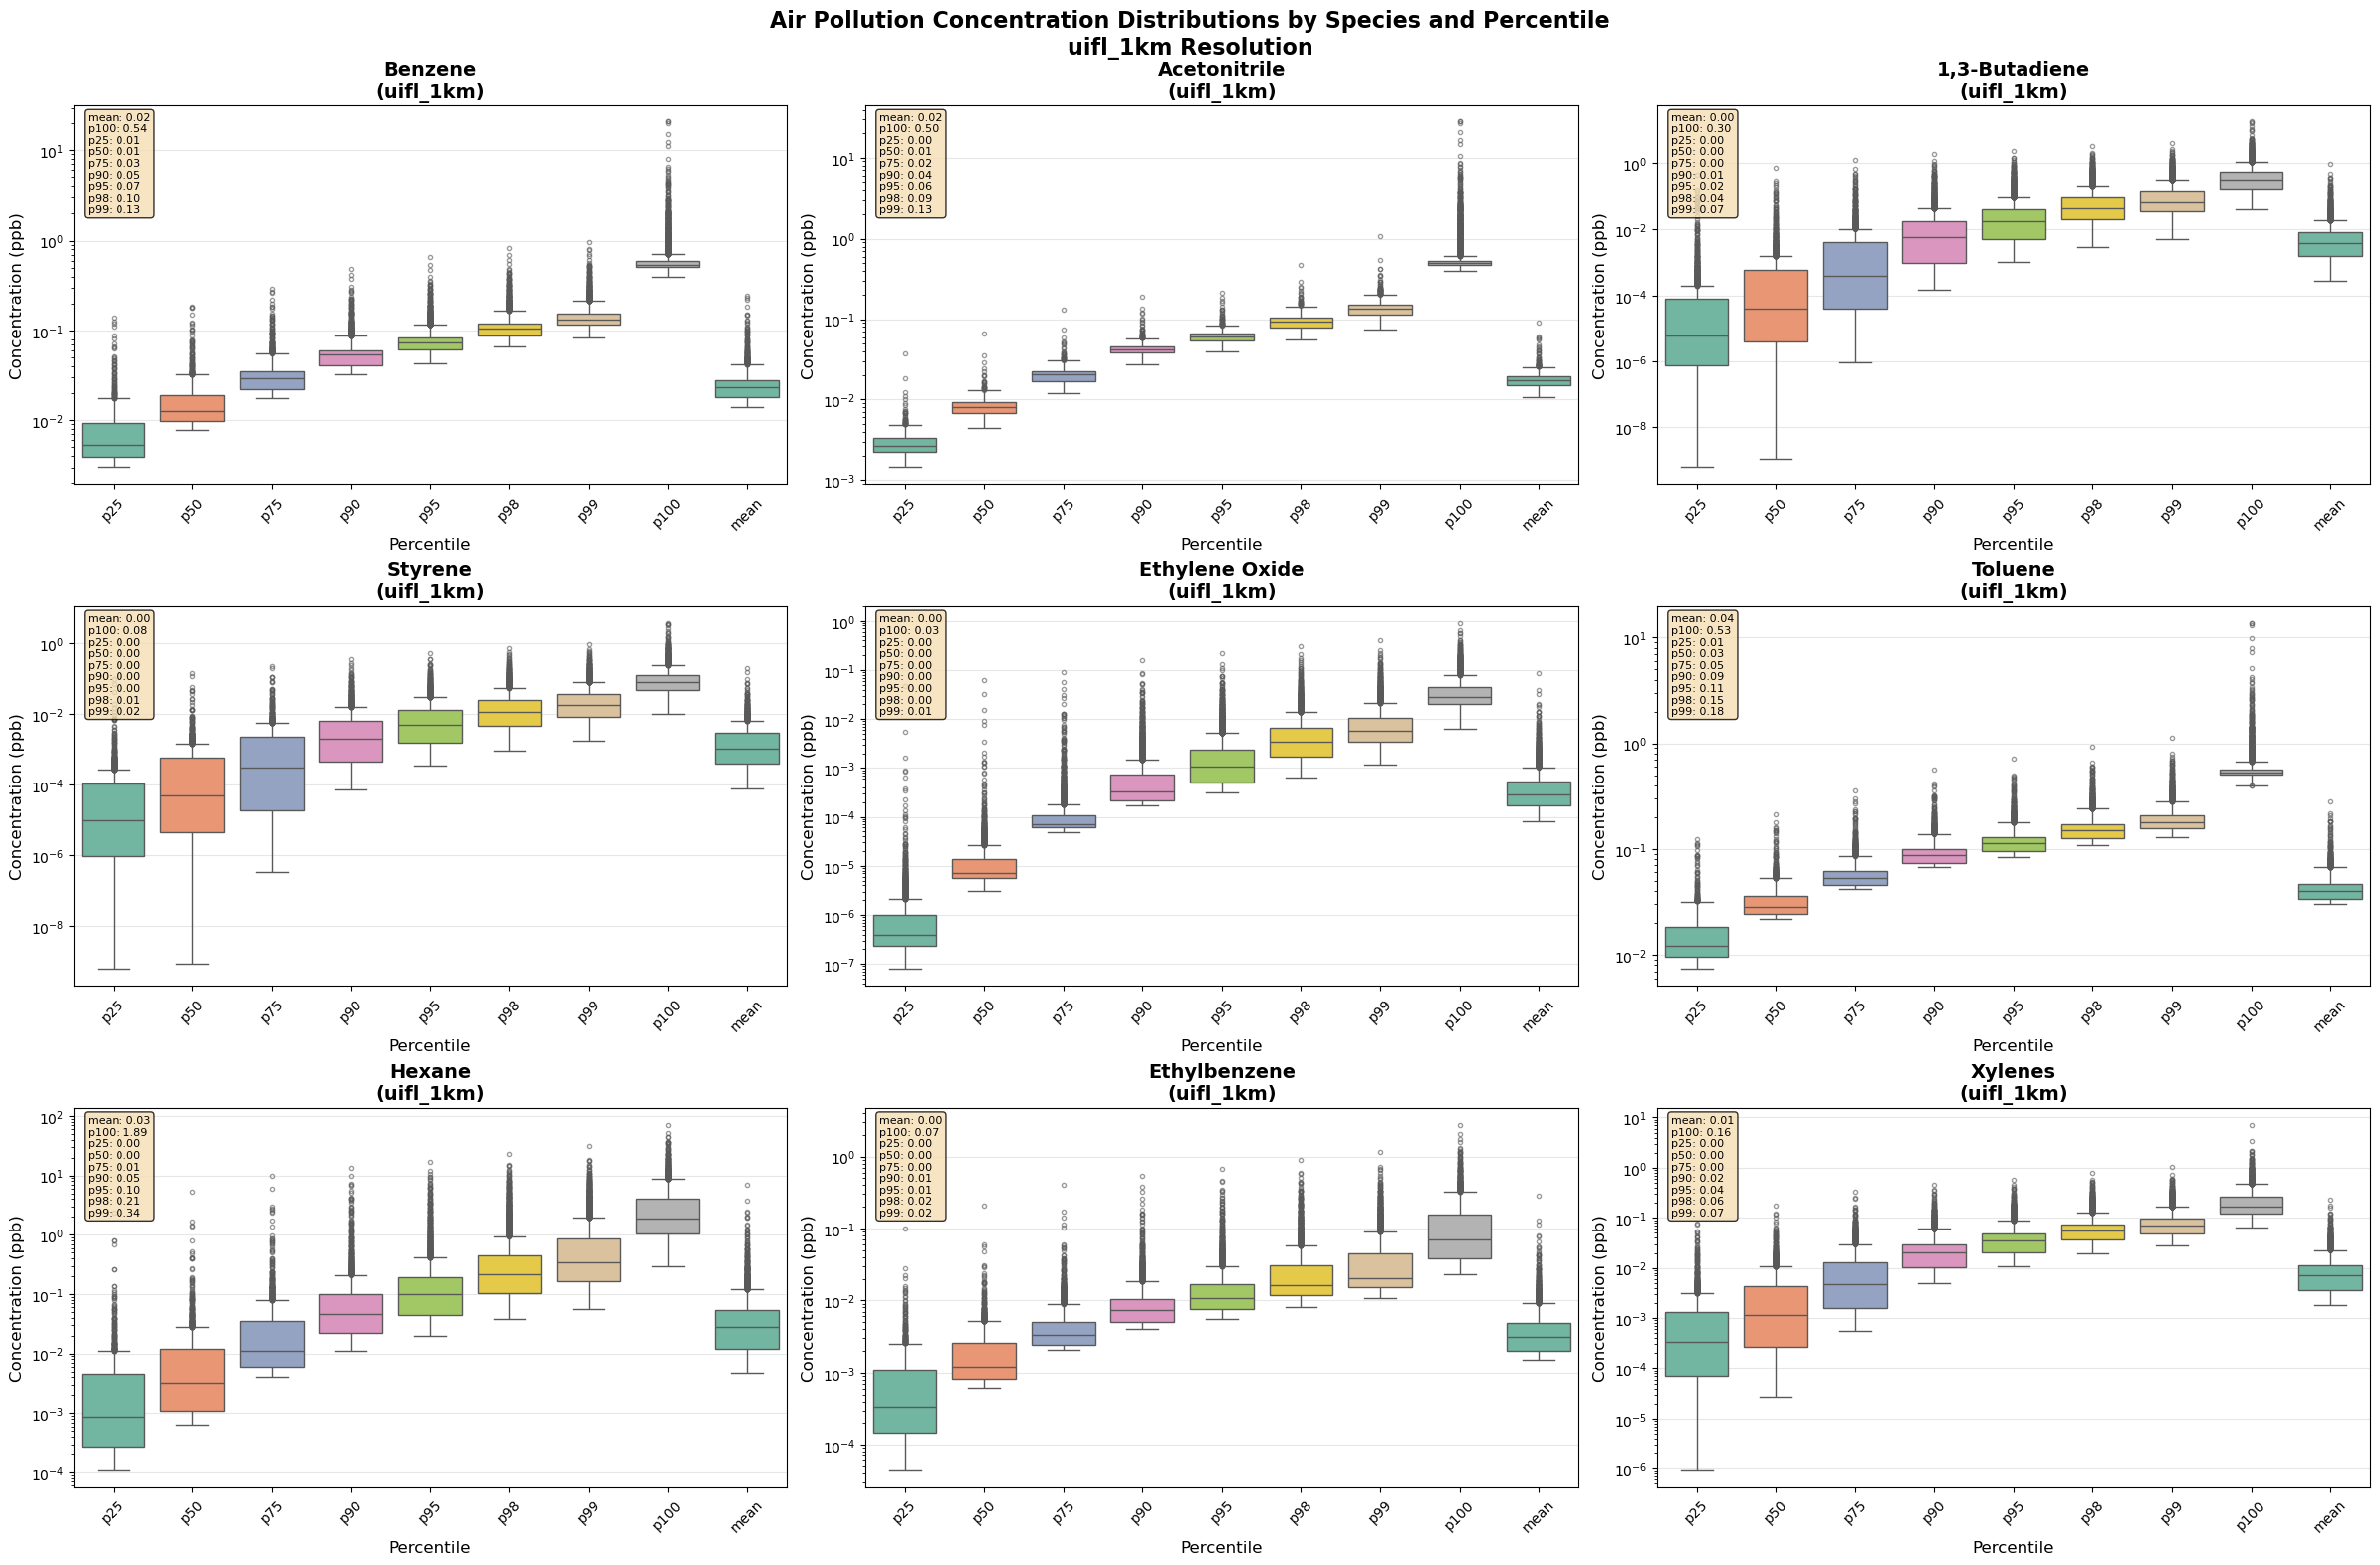

Box plot saved to: ip1_3av1_airdata\ip1_3av1_airdata_boxplots_uifl_1km.png


In [39]:
# Create comprehensive box plots for all species and percentiles
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def create_species_boxplots(air_pollution_dict, resolution='uifl_1km', figsize=(20, 15)):
    """
    Create box plots showing data distribution for each species across all percentiles
    
    Parameters:
    - air_pollution_dict: The air pollution data dictionary
    - resolution: Resolution to analyze ('uifl_1km' or 'uifl_4km')
    - figsize: Figure size for the plot grid
    """
    # Get all species and their statistics
    species_list = list(air_pollution_dict[resolution].keys())
    
    # Prepare data for plotting
    plot_data = []
    species_stats = {}
    
    print("Extracting data from rasters...")
    
    for species in species_list:
        species_stats[species] = {}
        stats_available = list(air_pollution_dict[resolution][species].keys())
        
        # Sort percentiles properly
        percentile_stats = [stat for stat in stats_available if stat.startswith('p')]
        percentile_stats = sorted(percentile_stats, key=lambda x: int(x[1:]))
        
        # Add mean if available
        if 'mean' in stats_available:
            percentile_stats.append('mean')
        
        for statistic in percentile_stats:
            # Extract raster data
            data_array = air_pollution_dict[resolution][species][statistic]['data'][0]
            
            # Remove zeros and invalid values
            valid_data = data_array[data_array > 0]
            
            if len(valid_data) > 0:
                species_stats[species][statistic] = valid_data
                
                # Prepare data for seaborn plotting
                for value in valid_data.flatten():
                    plot_data.append({
                        'Species': species,
                        'Statistic': statistic,
                        'Concentration': value
                    })
    
    # Convert to DataFrame for easier plotting
    import pandas as pd
    df = pd.DataFrame(plot_data)
    
    print(f"Data extracted for {len(species_list)} species")
    print(f"Total data points: {len(plot_data)}")
    
    return df, species_stats

def plot_species_boxplots_grid(df, species_stats, resolution='uifl_1km', figsize=(24, 16)):
    """
    Create a grid of box plots for all species
    """
    species_list = list(species_stats.keys())
    n_species = len(species_list)
    
    # Calculate grid dimensions
    n_cols = 3
    n_rows = (n_species + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    # Set up the plotting style
    plt.style.use('default')
    colors = plt.cm.Set2(np.linspace(0, 1, 10))
    
    for idx, species in enumerate(species_list):
        ax = axes[idx]
        
        # Get data for this species
        species_df = df[df['Species'] == species].copy()
        
        if len(species_df) > 0:
            # Create box plot with outliers
            box_plot = sns.boxplot(
                data=species_df, 
                x='Statistic', 
                y='Concentration',
                ax=ax,
                hue='Statistic',  # Assign x variable to hue for color coding
                palette='Set2',
                legend=False,     # Disable legend as suggested
                showfliers=True,  # Show outliers
                flierprops={'marker': 'o', 'markersize': 3, 'alpha': 0.6}
            )
            
            # Customize the plot
            ax.set_title(f'{species}\n({resolution})', fontsize=14, fontweight='bold')
            ax.set_xlabel('Percentile', fontsize=12)
            ax.set_ylabel('Concentration (ppb)', fontsize=12)
            
            # Use log scale for better visualization
            ax.set_yscale('log')
            
            # Rotate x-axis labels for better readability
            ax.tick_params(axis='x', rotation=45)
            
            # Add grid for better readability
            ax.grid(True, alpha=0.3, axis='y')
            
            # Add summary statistics as text
            stats_text = []
            for stat in sorted(species_stats[species].keys()):
                data = species_stats[species][stat]
                median_val = np.median(data)
                stats_text.append(f'{stat}: {median_val:.2f}')
            
            # Add text box with statistics
            textstr = '\n'.join(stats_text)
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
            ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=8,
                   verticalalignment='top', bbox=props)
        else:
            ax.text(0.5, 0.5, f'No data\nfor {species}', 
                   transform=ax.transAxes, ha='center', va='center')
            ax.set_title(species, fontsize=14)
    
    # Hide unused subplots
    for idx in range(n_species, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle(f'Air Pollution Concentration Distributions by Species and Percentile\n{resolution} Resolution', 
                fontsize=16, fontweight='bold', y=0.98)
    plt.subplots_adjust(top=0.92)
    plt.show()
    
    # Save plot using programname and resolution
    import os
    if not os.path.exists(programname):
        os.makedirs(programname)
    
    filename = f"{programname}_boxplots_{resolution}.png"
    filepath = os.path.join(programname, filename)
    fig.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Box plot saved to: {filepath}")

    return fig

def create_summary_statistics_table(species_stats, resolution='uifl_1km'):
    """
    Create a summary table of key statistics
    """
    import pandas as pd
    
    summary_data = []
    
    for species in species_stats:
        for statistic in species_stats[species]:
            data = species_stats[species][statistic]
            
            summary_data.append({
                'Species': species,
                'Percentile': statistic,
                'Count': len(data),
                'Min': np.min(data),
                'Q25': np.percentile(data, 25),
                'Median': np.median(data),
                'Q75': np.percentile(data, 75),
                'Max': np.max(data),
                'Mean': np.mean(data),
                'Std': np.std(data)
            })
    
    summary_df = pd.DataFrame(summary_data)
    
    print(f"\nSummary Statistics for {resolution}:")
    print("="*80)
    
    # Display formatted table
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.float_format', '{:.3f}'.format)
    
    print(summary_df.to_string(index=False))
    
    return summary_df

# Execute the box plot analysis
print("Creating box plots for air pollution data...")
print("This may take a moment to process all the raster data...")

# Extract data and create plots
df, species_stats = create_species_boxplots(air_pollution_dict, 'uifl_1km')

# Create the grid of box plots
fig = plot_species_boxplots_grid(df, species_stats, 'uifl_1km')

Creating box plots for air pollution data...
This may take a moment to process all the raster data...
Extracting data from rasters...
Data extracted for 9 species
Total data points: 620703


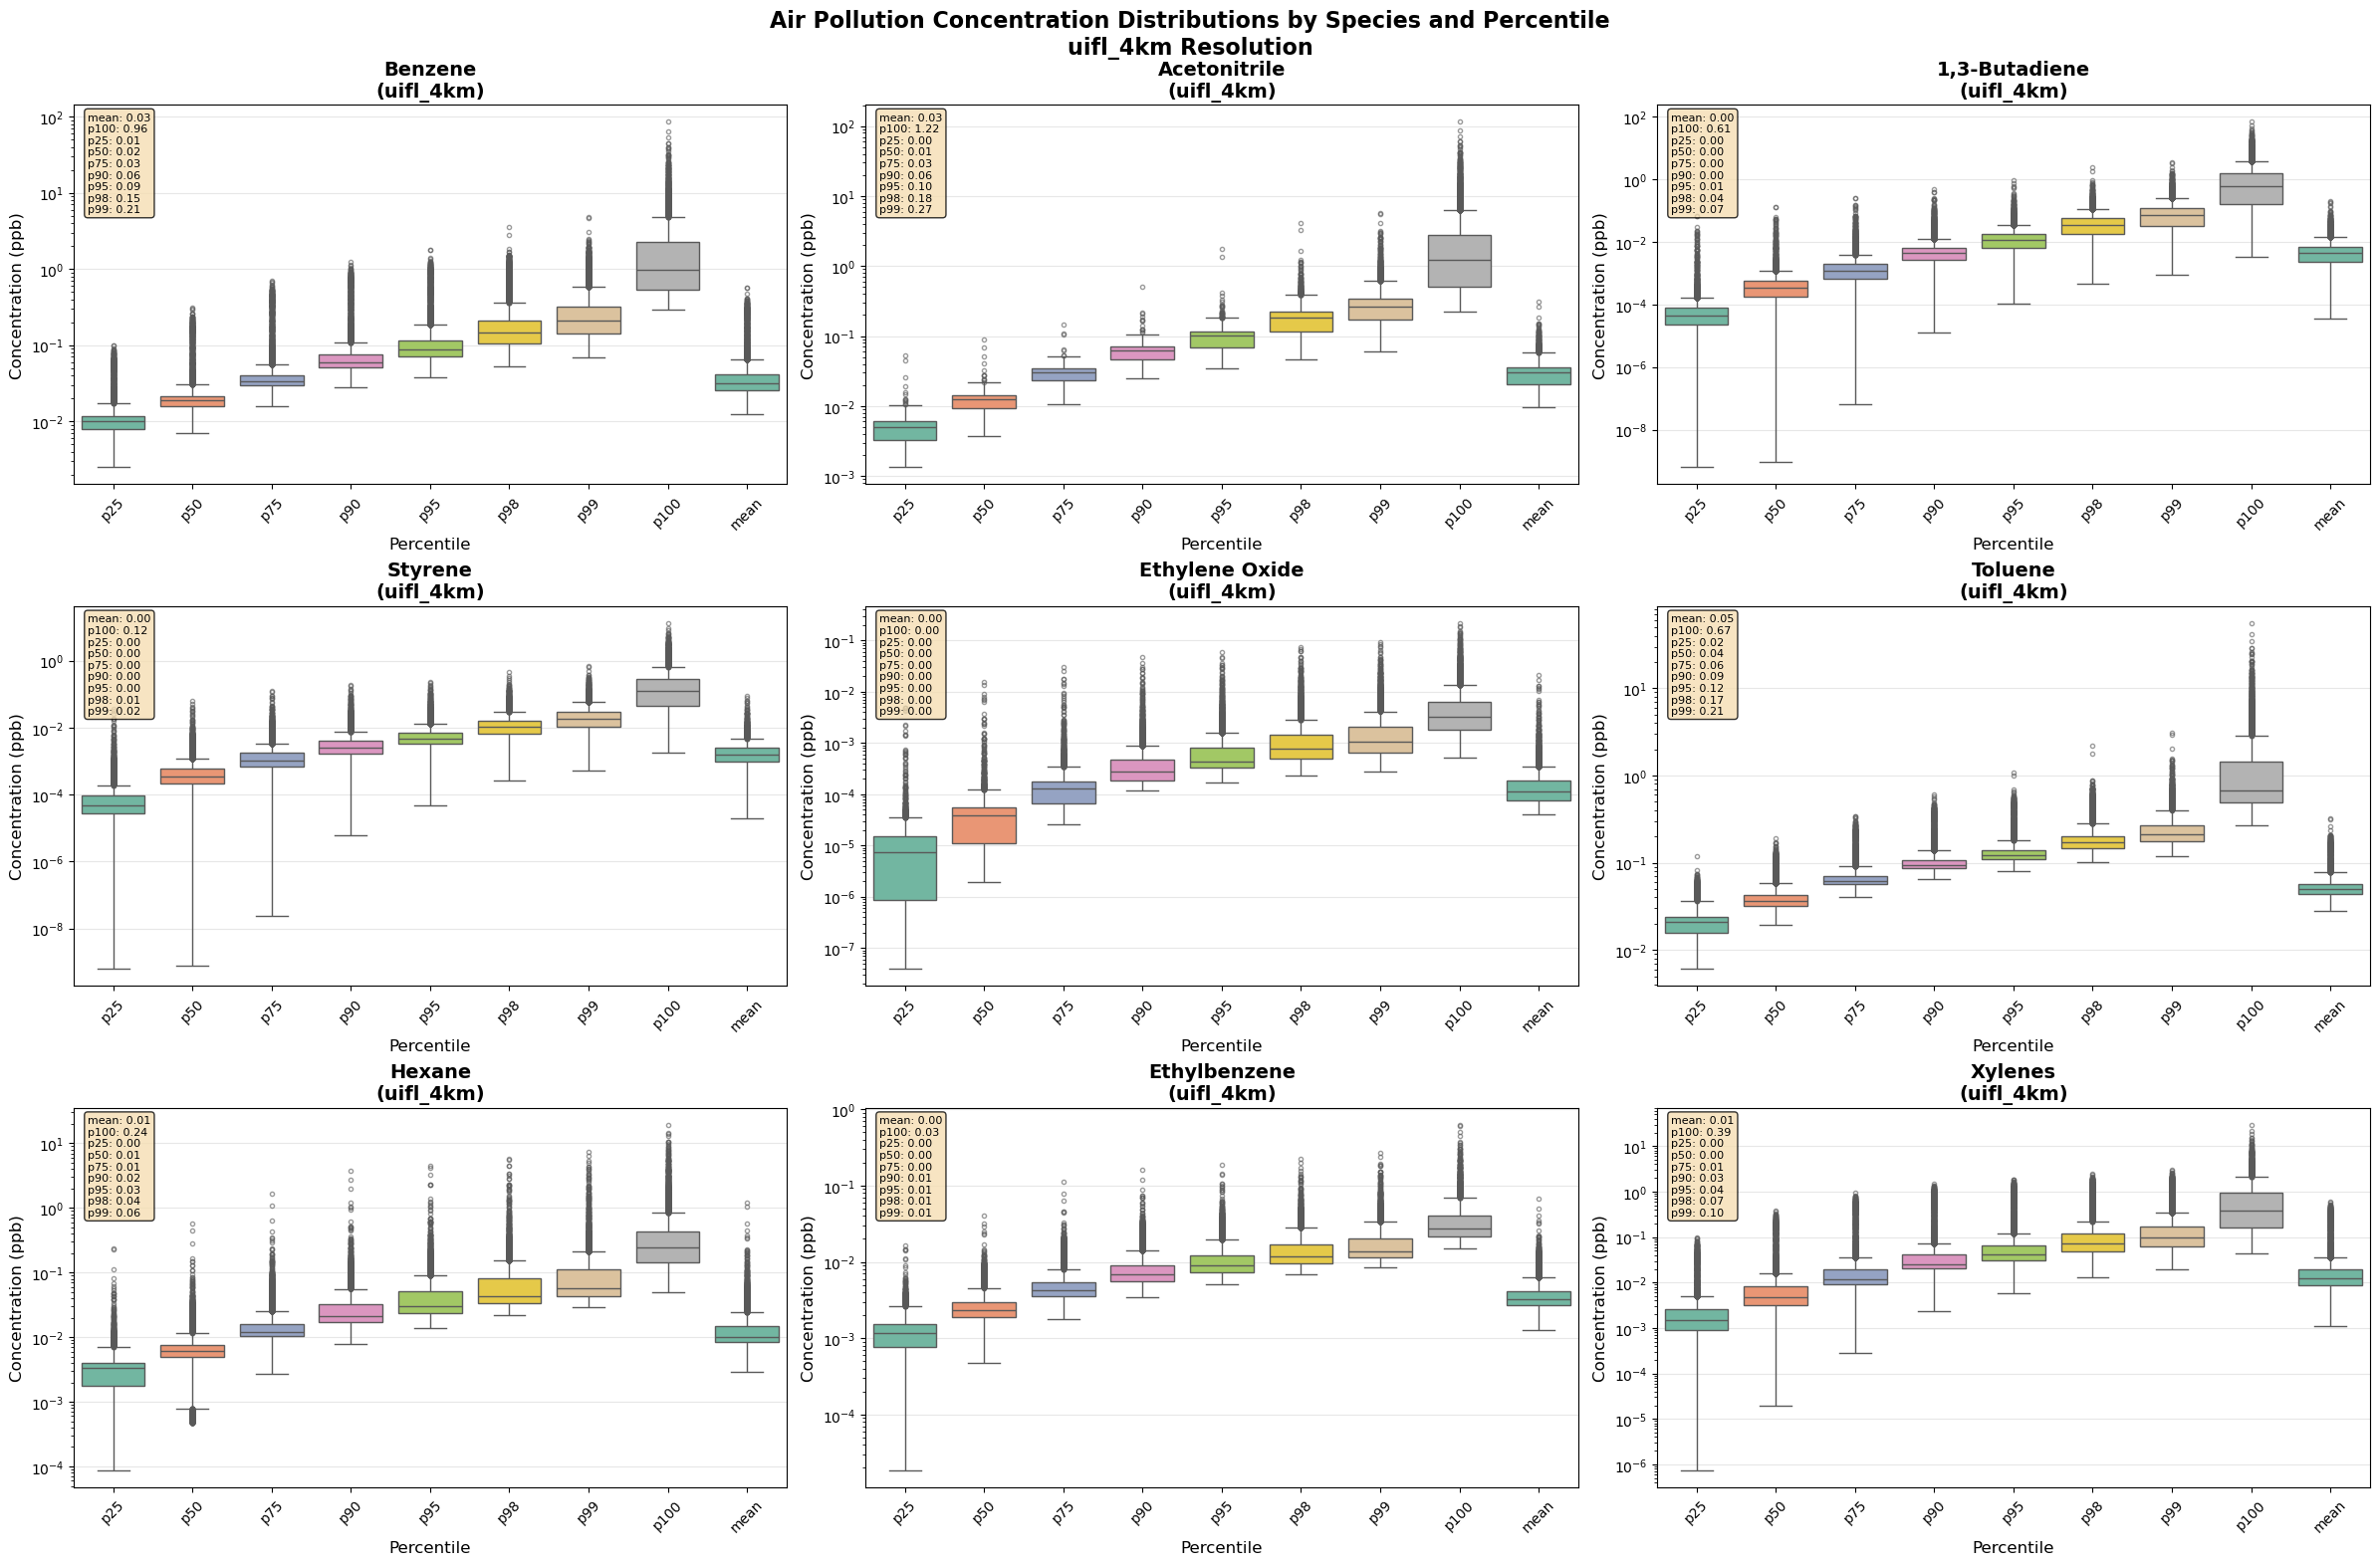

Box plot saved to: ip1_3av1_airdata\ip1_3av1_airdata_boxplots_uifl_4km.png


In [40]:
# Execute the box plot analysis
print("Creating box plots for air pollution data...")
print("This may take a moment to process all the raster data...")

# Extract data and create plots
df, species_stats = create_species_boxplots(air_pollution_dict, 'uifl_4km')

# Create the grid of box plots
fig = plot_species_boxplots_grid(df, species_stats, 'uifl_4km')